# CSCE 580 Project - IMDB Sentiment Analysis

## 1. Dataset Overview

In [ ]:
import sys
print("Using Python:", sys.executable)

#chatgpt to help debug package installation issues and environment setup
!{sys.executable} -m pip install pandas

!{sys.executable} -m pip show scikit-learn
!{sys.executable} -m pip install --upgrade --force-reinstall scikit-learn
!{sys.executable} -m pip install torch transformers tqdm
!{sys.executable} -m pip install seaborn

In [50]:
import pandas as pd
data = pd.read_csv("IMDB Dataset.csv") 
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [51]:
print(data.shape)
print(data.columns)
print(data['sentiment'].value_counts())

(50000, 2)
Index(['review', 'sentiment'], dtype='object')
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


### 1.1 Dataset description for report

- 50,000 reviews total
- Columns: `review` (text), `sentiment` (label)
#- Balanced between positive/negative

# 1.2 Train/test split

In [52]:
from sklearn.model_selection import train_test_split

X = data['review'].values
y = (data['sentiment'] == 'positive').astype(int).values 

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, 
    random_state=42,
    stratify=y 
)

len(X_train), len(X_test)


(40000, 10000)

## 2. Classical Machine Learning Model 

### 2.1 TF-IDF feature extraction

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape


((40000, 20000), (10000, 20000))

### 2.2 Train Logistic regression classifier

In [10]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, n_jobs=-1)
clf.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### 2.3 Evaluation metrics for classical model

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_clf = clf.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_clf, target_names=['neg', 'pos']))

cm_clf = confusion_matrix(y_test, y_pred_clf)
cm_clf

              precision    recall  f1-score   support

         neg       0.91      0.89      0.90      5000
         pos       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



array([[4458,  542],
       [ 455, 4545]])

### 2.4 Confusion matrix for classical model

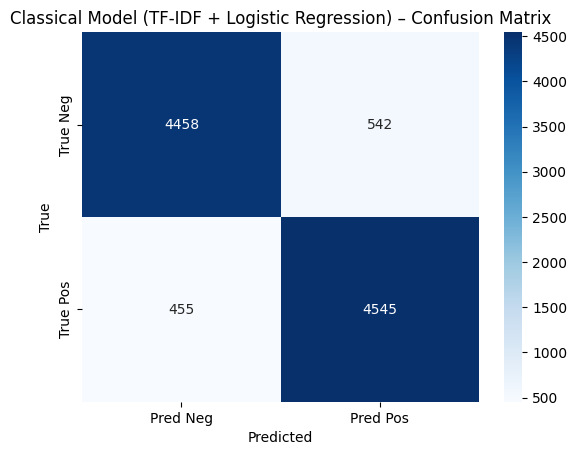

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.heatmap(cm_clf,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=['Pred Neg','Pred Pos'],
            yticklabels=['True Neg','True Pos'])
plt.title("Classical Model (TF-IDF + Logistic Regression) – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### 3.1 Imports and setup

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # use AdamW instead of transformers
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from tqdm.auto import tqdm

device = torch.device("cpu")
device


device(type='cpu')

### 3.2 Train/validation split for DistilBERT

In [ ]:
from sklearn.model_selection import train_test_split

X_train_small = X_train[:10000]
y_train_small = y_train[:10000]
print(len(X_train_small), len(y_train_small))

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_small,
    y_train_small,
    test_size=0.1, 
    random_state=42,
    stratify=y_train_small
)

len(X_train_sub), len(X_val)

10000 10000


(9000, 1000)

### 3.3 Tokenization and PyTorch Dataset

In [19]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

MAX_LEN = 256

class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        enc = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

train_dataset = IMDBDataset(X_train_sub, y_train_sub, tokenizer, MAX_LEN)
val_dataset   = IMDBDataset(X_val,       y_val,       tokenizer, MAX_LEN)
test_dataset  = IMDBDataset(X_test,      y_test,      tokenizer, MAX_LEN)

len(train_dataset), len(val_dataset), len(test_dataset)

(9000, 1000, 10000)

### 3.4 Dataloaders

In [20]:
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_EVAL = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE_EVAL,   shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE_EVAL,   shuffle=False)

len(train_loader), len(val_loader), len(test_loader)

(563, 32, 313)

### 3.5 Base DistilBERT (no fine-tuning) evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Loading pretrained model
model_base = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
).to(device)

model_base.eval()

all_base_preds = []
all_base_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Base DistilBERT eval"):
        labels = batch['labels'].numpy()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_base(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_base_preds.extend(preds)
        all_base_labels.extend(labels)

print(classification_report(all_base_labels, all_base_preds, target_names=['neg', 'pos']))

cm_base = confusion_matrix(all_base_labels, all_base_preds)
cm_base

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Base DistilBERT eval: 100%|██████████████████████████████████████████| 313/313 [04:26<00:00,  1.17it/s]

              precision    recall  f1-score   support

         neg       0.00      0.00      0.00      5000
         pos       0.50      1.00      0.67      5000

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000




/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

array([[   0, 5000],
       [   0, 5000]])

### 3.6 Fine-tuning DistilBERT

In [ ]:
model_ft = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
).to(device)

optimizer = AdamW(model_ft.parameters(), lr=2e-5)

EPOCHS = 2 #Can increase

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

from sklearn.metrics import accuracy_score

for epoch in range(EPOCHS):
    # Train
    model_ft.train()
    epoch_train_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - train"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_ft(**batch)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        labels = batch['labels'].detach().cpu().numpy()
        all_train_preds.extend(preds)
        all_train_labels.extend(labels)

    train_loss = epoch_train_loss / len(train_loader)
    train_acc = accuracy_score(all_train_labels, all_train_preds)

    # Validation
    model_ft.eval()
    epoch_val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} - val"):
            labels = batch['labels'].numpy()
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model_ft(**batch)
            loss = outputs.loss
            logits = outputs.logits

            epoch_val_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_val_preds.extend(preds)
            all_val_labels.extend(labels)

    val_loss = epoch_val_loss / len(val_loader)
    val_acc = accuracy_score(all_val_labels, all_val_preds)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
          f"train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - val: 100%|███████████████████████████████████████████████████| 32/32 [00:27<00:00,  1.15it/s]


Epoch 1: train_loss=0.3333, val_loss=0.2420, train_acc=0.8541, val_acc=0.9040


Epoch 2 - val: 100%|███████████████████████████████████████████████████| 32/32 [00:26<00:00,  1.21it/s]

Epoch 2: train_loss=0.1795, val_loss=0.2298, train_acc=0.9354, val_acc=0.9150


### 3.7 Training and validation curves

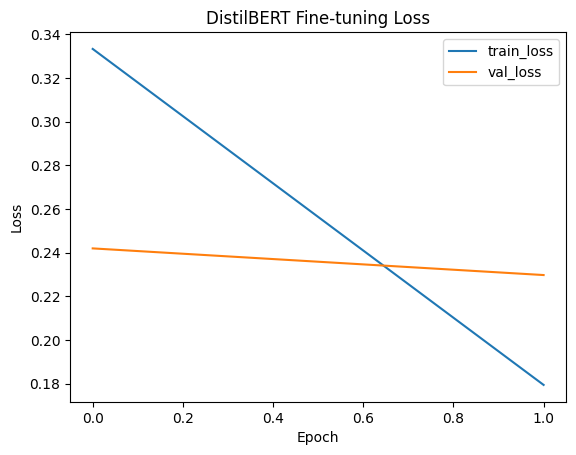

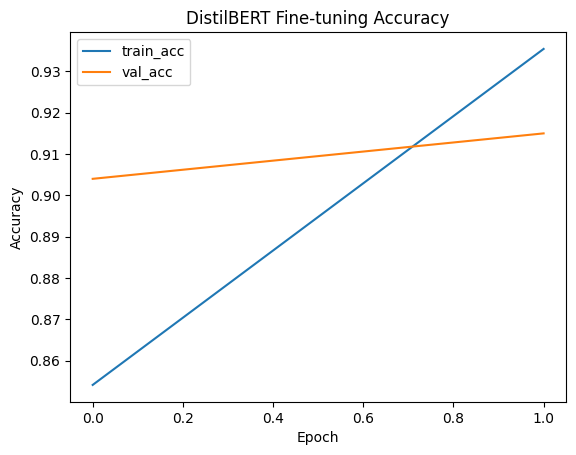

In [23]:
import matplotlib.pyplot as plt

# Loss curves
plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("DistilBERT Fine-tuning Loss")
plt.show()

# Accuracy curves
plt.figure()
plt.plot(train_accuracies, label="train_acc")
plt.plot(val_accuracies, label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("DistilBERT Fine-tuning Accuracy")
plt.show()

### 3.8 Eval of fine-tuned DistilBERT on test set

In [24]:
model_ft.eval()
all_ft_preds = []
all_ft_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Fine-tuned DistilBERT eval"):
        labels = batch['labels'].numpy()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_ft(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_ft_preds.extend(preds)
        all_ft_labels.extend(labels)

print(classification_report(all_ft_labels, all_ft_preds, target_names=['neg', 'pos']))

from sklearn.metrics import confusion_matrix
cm_ft = confusion_matrix(all_ft_labels, all_ft_preds)
cm_ft

Fine-tuned DistilBERT eval: 100%|████████████████████████████████████| 313/313 [04:27<00:00,  1.17it/s]

              precision    recall  f1-score   support

         neg       0.90      0.90      0.90      5000
         pos       0.90      0.90      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



array([[4508,  492],
       [ 504, 4496]])

## 4. GPT Model

### 4.1 Imports and model setup

In [25]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch

device = torch.device("cpu")
device

device(type='cpu')

In [31]:
gpt2_model_name = "gpt2"

gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)

if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

gpt2_model = AutoModel.from_pretrained(gpt2_model_name).to(device)
gpt2_model.config.pad_token_id = gpt2_tokenizer.pad_token_id 
gpt2_model.eval()


GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

### 4.2 Building GPT2 embeddings

In [32]:
def get_gpt2_embeddings(texts, batch_size=16, max_len=128):
    """
    texts: list/array of strings
    returns: numpy array of shape (num_texts, hidden_size)
    """
    all_embs = []

    texts = list(texts)

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        enc = gpt2_tokenizer(
            batch_texts,
            truncation=True,
            padding="max_length",
            max_length=max_len,
            return_tensors="pt"
        )

        enc = {k: v.to(device) for k, v in enc.items()}

        with torch.no_grad():
            outputs = gpt2_model(**enc)
            last_hidden = outputs.last_hidden_state
            emb = last_hidden.mean(dim=1) 

        all_embs.append(emb.cpu().numpy())

    return np.vstack(all_embs)


#### 4.2.1 Subsample data for GPT2

In [29]:
N_TRAIN_GPT = 4000
N_TEST_GPT  = 2000

X_train_gpt = X_train[:N_TRAIN_GPT]
y_train_gpt = y_train[:N_TRAIN_GPT]

X_test_gpt  = X_test[:N_TEST_GPT]
y_test_gpt  = y_test[:N_TEST_GPT]

len(X_train_gpt), len(X_test_gpt)

(4000, 2000)

#### 4.2.2 Compute GPT2 embeddings for train and test

In [33]:
X_train_gpt_emb = get_gpt2_embeddings(X_train_gpt, batch_size=16, max_len=128)
X_test_gpt_emb  = get_gpt2_embeddings(X_test_gpt,  batch_size=16, max_len=128)
X_train_gpt_emb.shape, X_test_gpt_emb.shape

((4000, 768), (2000, 768))

### 4.3 Train Logistic Regression on GPT2 embeddings

In [34]:
from sklearn.linear_model import LogisticRegression

gpt_clf = LogisticRegression(max_iter=1000, n_jobs=-1)
gpt_clf.fit(X_train_gpt_emb, y_train_gpt)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### 4.4 Evaluate GPT based sentiment classifier

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_gpt = gpt_clf.predict(X_test_gpt_emb)

print(classification_report(y_test_gpt, y_pred_gpt, target_names=['neg', 'pos']))

cm_gpt = confusion_matrix(y_test_gpt, y_pred_gpt)
cm_gpt

              precision    recall  f1-score   support

         neg       0.82      0.82      0.82      1005
         pos       0.82      0.81      0.82       995

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



array([[829, 176],
       [185, 810]])

### 4.5 Confusion matrix for GPT model

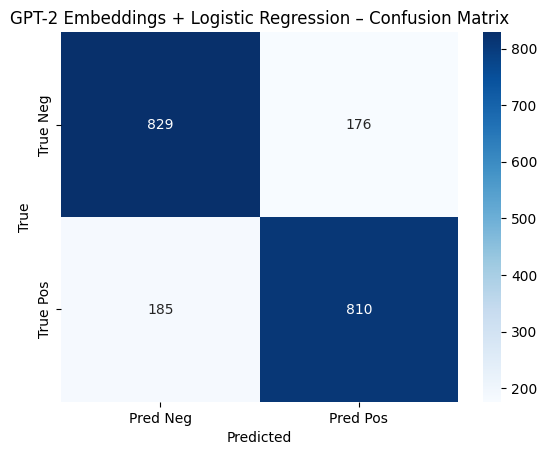

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.heatmap(cm_gpt,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=['Pred Neg','Pred Pos'],
            yticklabels=['True Neg','True Pos'])
plt.title("GPT-2 Embeddings + Logistic Regression – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 5. Evaluation- Metrics, Confusion Matrices, Time

### 5.1 Metric comparison across models

In [38]:
from sklearn.metrics import classification_report
import pandas as pd

labels = ['neg', 'pos']

report_clf  = classification_report(y_test,          y_pred_clf,
                                    target_names=labels, output_dict=True, zero_division=0)
report_base = classification_report(all_base_labels, all_base_preds,
                                    target_names=labels, output_dict=True, zero_division=0)
report_ft   = classification_report(all_ft_labels,   all_ft_preds,
                                    target_names=labels, output_dict=True, zero_division=0)
report_gpt  = classification_report(y_test_gpt,      y_pred_gpt,
                                    target_names=labels, output_dict=True, zero_division=0)

rows = [
    {
        "model": "TF-IDF + Logistic Regression",
        "accuracy": report_clf["accuracy"],
        "precision_pos": report_clf["pos"]["precision"],
        "recall_pos": report_clf["pos"]["recall"],
        "f1_pos": report_clf["pos"]["f1-score"],
    },
    {
        "model": "Base DistilBERT",
        "accuracy": report_base["accuracy"],
        "precision_pos": report_base["pos"]["precision"],
        "recall_pos": report_base["pos"]["recall"],
        "f1_pos": report_base["pos"]["f1-score"],
    },
    {
        "model": "Fine-tuned DistilBERT",
        "accuracy": report_ft["accuracy"],
        "precision_pos": report_ft["pos"]["precision"],
        "recall_pos": report_ft["pos"]["recall"],
        "f1_pos": report_ft["pos"]["f1-score"],
    },
    {
        "model": "GPT-2 Embeddings + Logistic Regression",
        "accuracy": report_gpt["accuracy"],
        "precision_pos": report_gpt["pos"]["precision"],
        "recall_pos": report_gpt["pos"]["recall"],
        "f1_pos": report_gpt["pos"]["f1-score"],
    },
]

metrics_data = pd.DataFrame(rows)
metrics_data


,model,accuracy,precision_pos,recall_pos,f1_pos
0,TF-IDF + Logistic Regression,0.9003,0.893454,0.90900,0.901160
1,Base DistilBERT,0.5000,0.500000,1.00000,0.666667
2,Fine-tuned DistilBERT,0.9004,0.901363,0.89920,0.900280
3,GPT-2 Embeddings + Logistic Regression,0.8195,0.821501,0.81407,0.817769


### 5.2 Confusion matrices

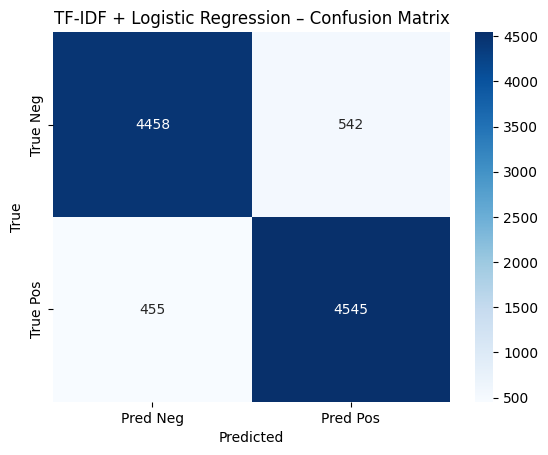

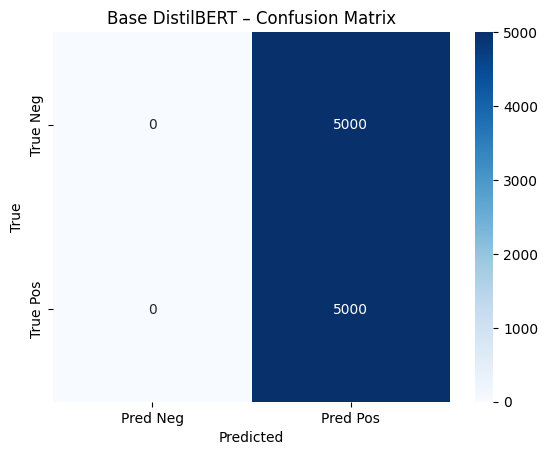

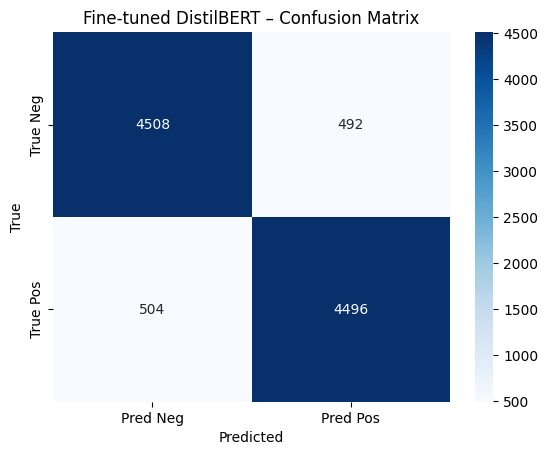

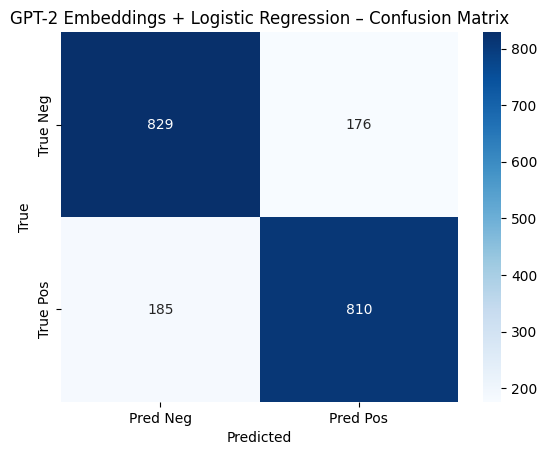

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cm(cm, title):
    plt.figure()
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=['Pred Neg','Pred Pos'],
                yticklabels=['True Neg','True Pos'])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_cm(cm_clf,  "TF-IDF + Logistic Regression – Confusion Matrix")
plot_cm(cm_base, "Base DistilBERT – Confusion Matrix")
plot_cm(cm_ft,   "Fine-tuned DistilBERT – Confusion Matrix")
plot_cm(cm_gpt,  "GPT-2 Embeddings + Logistic Regression – Confusion Matrix")

### 5.3 Rough training and inference time (time complexity)

#### 5.3.1 TF-IDF and Logistic Regression

In [40]:
import time

start = time.time()
clf_time_model = LogisticRegression(max_iter=1000, n_jobs=-1)
clf_time_model.fit(X_train_tfidf, y_train)
end = time.time()
print(f"Classical model training time (full train set): {end - start:.2f} seconds")

start = time.time()
_ = clf_time_model.predict(X_test_tfidf[:1000])
end = time.time()
print(f"Classical model inference on 1000 samples: {end - start:.4f} seconds")
# 5.3.1

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Classical model training time (full train set): 2.61 seconds
Classical model inference on 1000 samples: 0.0043 seconds


#### 5.3.2 GPT2 embeddings and Logistic Regression

In [42]:
N_TRAIN_GPT = len(X_train_gpt) 
N_TEST_GPT  = len(X_test_gpt)

start = time.time()
X_train_gpt_emb_t = get_gpt2_embeddings(X_train_gpt, batch_size=16, max_len=128)
X_test_gpt_emb_t  = get_gpt2_embeddings(X_test_gpt,  batch_size=16, max_len=128)
emb_time = time.time() - start

start = time.time()
gpt_time_clf = LogisticRegression(max_iter=1000, n_jobs=-1)
gpt_time_clf.fit(X_train_gpt_emb_t, y_train_gpt)
train_time = time.time() - start

start = time.time()
_ = gpt_time_clf.predict(X_test_gpt_emb_t[:500]) 
infer_time = time.time() - start

print(f"GPT-2 embedding time for {N_TRAIN_GPT+N_TEST_GPT} samples: {emb_time:.2f} seconds")
print(f"GPT-2 classifier training time: {train_time:.2f} seconds")
print(f"GPT-2 classifier inference on 500 samples: {infer_time:.4f} seconds")
# 5.3.2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

GPT-2 embedding time for 6000 samples: 194.12 seconds
GPT-2 classifier training time: 4.05 seconds
GPT-2 classifier inference on 500 samples: 0.0028 seconds


/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 5.3.3 Fine-tuned DistilBERT

In [ ]:
import time

start = time.time()
model_ft.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        _ = model_ft(**batch).logits
end = time.time()

print(f"Fine-tuned DistilBERT inference over full test set: {end - start:.2f} seconds")


Fine-tuned DistilBERT inference over full test set: 267.41 seconds


## 6. AI Testcases 

### 6.1 Helper for all models

In [45]:
label_map = {0: "neg", 1: "pos"}

def predict_all_models(text):
    tfidf_vec = tfidf.transform([text])
    pred_clf = int(clf.predict(tfidf_vec)[0])

    enc = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors="pt"
    )
    enc = {k: v.to(device) for k, v in enc.items()}

    model_ft.eval()
    with torch.no_grad():
        logits_ft = model_ft(**enc).logits
        pred_ft = int(torch.argmax(logits_ft, dim=1).item())

    model_base.eval()
    with torch.no_grad():
        logits_base = model_base(**enc).logits
        pred_base = int(torch.argmax(logits_base, dim=1).item())

    gpt_emb = get_gpt2_embeddings([text], batch_size=1, max_len=128)
    pred_gpt = int(gpt_clf.predict(gpt_emb)[0])

    return {
        "classical": label_map[pred_clf],
        "base_distilbert": label_map[pred_base],
        "finetuned_distilbert": label_map[pred_ft],
        "gpt": label_map[pred_gpt],
    }


### 6.2 Custom testcases

In [48]:
testcases = [
    {
        "id": 1,
        "text": "I absolutely loved this movie. The acting was amazing and I left the movie theater very happy.",
        "true_label": "pos",
    },
    {
        "id": 2,
        "text": "The film had a few interesting moments and was okay, but overall it was boring and kind of long.",
        "true_label": "neg",
    },
    {
        "id": 3,
        "text": "If you like wasting time, you'll like this movie.",
        "true_label": "neg",  # sarcasm to test result
    },
]

### 6.3 Predictions for testcases

In [49]:
import pandas as pd

rows = []
for case in testcases:
    preds = predict_all_models(case["text"])
    row = {
        "id": case["id"],
        "text": case["text"],
        "true_label": case["true_label"],
        **preds,
    }
    rows.append(row)

testcases_data = pd.DataFrame(rows)
testcases_data

,id,text,true_label,classical,base_distilbert,finetuned_distilbert,gpt
0,1,I absolutely loved this movie. The acting was ...,pos,pos,pos,pos,pos
1,2,The film had a few interesting moments and was...,neg,neg,pos,neg,neg
2,3,"If you like wasting time, you'll like this movie.",neg,neg,pos,neg,neg


### Report.md has full info and analysis based on this notebook